In [87]:
# perform imports
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

In [88]:
# load dataset with the appropriate encoding; other encodings do not load properly
data_raw = pd.read_csv('us_accidents_weather_data.csv', encoding="ISO-8859-1")

In [89]:
# determine the total number of rows with NAs
print(f"Number of rows with NAs: {len(data_raw) - len(data_raw.dropna()):,}")

Number of rows with NAs: 638,003


In [90]:
# determine where NAs come from
print(f"Source of NAs per row: \n{data_raw.isna().sum()}")

Source of NAs per row: 
Unnamed: 0                0
ID                        0
Severity                  0
Weather_Timestamp     50736
Temperature(F)        69274
Wind_Chill(F)        469643
Humidity(%)           73092
Pressure(in)          59200
Visibility(mi)        70546
Wind_Speed(mph)      157944
Precipitation(in)    549458
Weather_Condition     70636
Sunrise_Sunset         2867
dtype: int64


In [91]:
# weather timestamp has 50k rows, look at other column values in those rows
print(f"Values in rows with NA weather timestamps: \n{data_raw[data_raw['Weather_Timestamp'].isna()].isna().sum()}")

Values in rows with NA weather timestamps: 
Unnamed: 0               0
ID                       0
Severity                 0
Weather_Timestamp    50736
Temperature(F)       50736
Wind_Chill(F)        50736
Humidity(%)          50736
Pressure(in)         50736
Visibility(mi)       50736
Wind_Speed(mph)      50736
Precipitation(in)    50736
Weather_Condition    50736
Sunrise_Sunset         565
dtype: int64


In rows where `Weather_Timestamp` is null, only `Severity` and `Sunrise_Sunset` are present. On their own, these two values don't provide much information for analysis, so it seems safe to drop all rows with a null `Weather_Timestamp`. This accounts for 50,736 rows with null values.

In [92]:
# drop rows with a null weather timestamp
data_cleaned = data_raw.dropna(subset='Weather_Timestamp')
# set remaining weather timestamps to datetime
data_cleaned['Weather_Timestamp'] = data_cleaned['Weather_Timestamp'].astype('datetime64[ns]')

In [93]:
# determine the total number of remaining rows with NAs
print(f"Number of remaining rows with NAs: {len(data_cleaned) - len(data_cleaned.dropna()):,}")

Number of remaining rows with NAs: 587,267


Following the same logic as above, it seems reasonable that we can safely drop all rows where every value except `ID`, `Severity`, `Weather_Timestamp`, and `Sunrise_Sunset` are null.

In [94]:
# drop rows without valuable information
data_cleaned = data_cleaned.dropna(subset=['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
                                           'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition'], how='all')

In [95]:
# determine the total number of remaining rows with NAs
print(f"Number of remaining rows with NAs: {len(data_cleaned) - len(data_cleaned.dropna()):,}")

Number of remaining rows with NAs: 584,380


In [96]:
# determine where remaining null values come from
print(f"Source of remaining NAs per row: \n{data_cleaned.isna().sum()}")

Source of remaining NAs per row: 
Unnamed: 0                0
ID                        0
Severity                  0
Weather_Timestamp         0
Temperature(F)        15651
Wind_Chill(F)        416020
Humidity(%)           19469
Pressure(in)           5577
Visibility(mi)        16923
Wind_Speed(mph)      104321
Precipitation(in)    495835
Weather_Condition     17013
Sunrise_Sunset         2300
dtype: int64


In [97]:
print(f"Distribution of non-null Sunrise_Sunset values: \n{data_cleaned['Sunrise_Sunset'].value_counts()}")

Distribution of non-null Sunrise_Sunset values: 
Day      1781781
Night    1007638
Name: Sunrise_Sunset, dtype: int64


<BarContainer object of 4 artists>

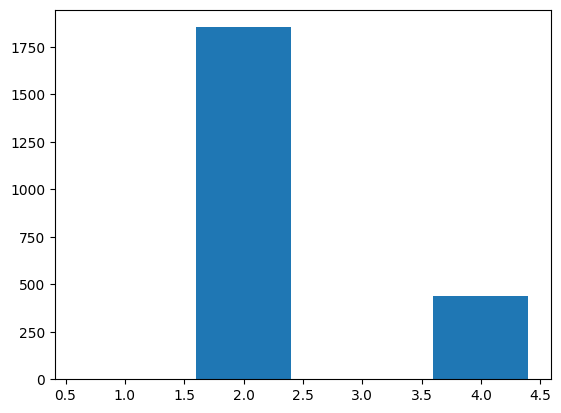

In [98]:
test = data_cleaned[data_cleaned['Sunrise_Sunset'].isna()]['Severity'].value_counts()

plt.bar(list(test.index), list(test))

<BarContainer object of 4 artists>

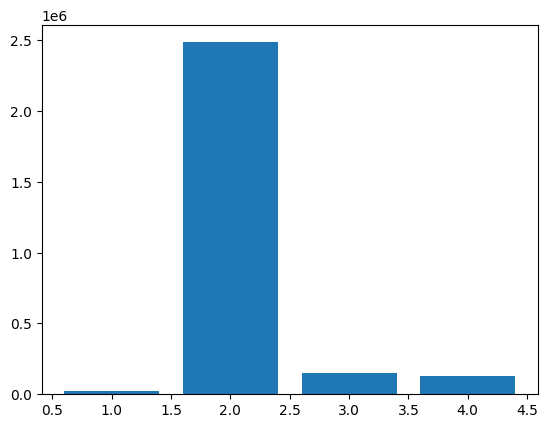

In [99]:
data_cleaned['Severity'].value_counts()

plt.bar(list(data_cleaned['Severity'].value_counts().index), list(data_cleaned['Severity'].value_counts()))

Compared to the size of the dataset, there are very few rows with null `Sunrise_Sunset` values. However, these rows contain a disproportionate number of accidents with a severity of 4. As a result, they shouldn't simply be dropped. Luckily, because of the `Weather_Timestamp` field, the `Sunrise_Sunset` field can be somewhat reliably estimated.

In [100]:
# estimate the Sunrise_Sunset value for null columns based on typical times of day/night
mask1 = data_cleaned['Weather_Timestamp'].dt.time >= dt.time(7, 30)
mask2 = data_cleaned['Weather_Timestamp'].dt.time <= dt.time(19, 30)
mask3 = data_cleaned['Sunrise_Sunset'].isna()

data_cleaned.loc[mask1 & mask2 & mask3, 'Sunrise_Sunset'] = 'Day'
data_cleaned['Sunrise_Sunset'] = data_cleaned['Sunrise_Sunset'].fillna('Night')

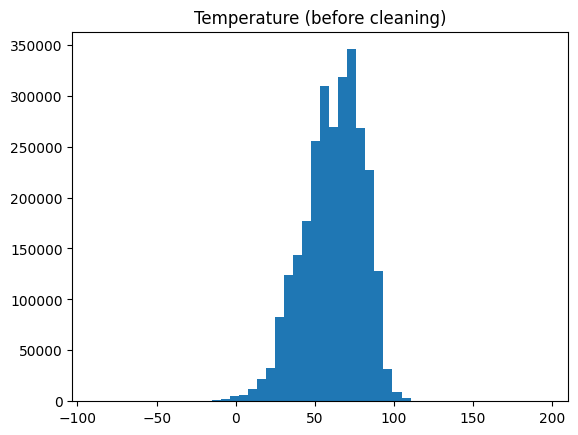

In [101]:
plt.hist(data_cleaned['Temperature(F)'], bins=50)
plt.title("Temperature (before cleaning)")
plt.show()

In [102]:
# temperature follows a distribution that seems reasonable to sample from randomly
temp_sample = data_cleaned['Temperature(F)'].dropna().sample(n=len(data_cleaned), replace=True)
temp_sample.index = data_cleaned.index
data_cleaned['Temperature(F)'] = data_cleaned['Temperature(F)'].fillna(temp_sample)

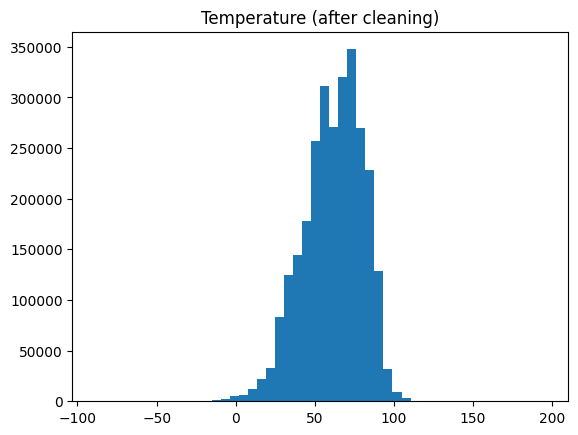

In [103]:
# confirm that the distribution is relatively unchanged
plt.hist(data_cleaned['Temperature(F)'], bins=50)
plt.title("Temperature (after cleaning)")
plt.show()

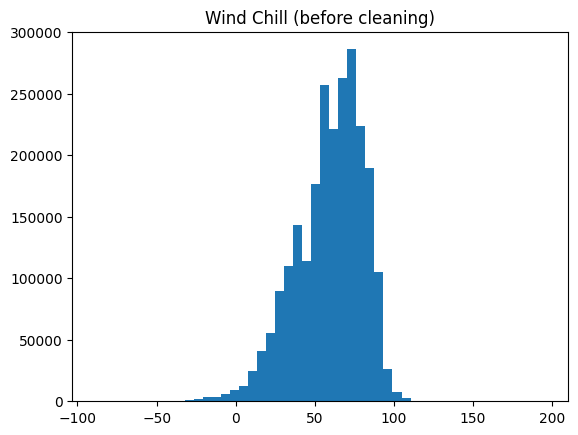

In [104]:
plt.hist(data_cleaned['Wind_Chill(F)'], bins=50)
plt.title("Wind Chill (before cleaning)")
plt.show()

In [105]:
# wind chill follows a distribution that seems reasonable to sample from randomly
wind_chill_sample = data_cleaned['Wind_Chill(F)'].dropna().sample(n=len(data_cleaned), replace=True)
wind_chill_sample.index = data_cleaned.index
data_cleaned['Wind_Chill(F)'] = data_cleaned['Wind_Chill(F)'].fillna(wind_chill_sample)

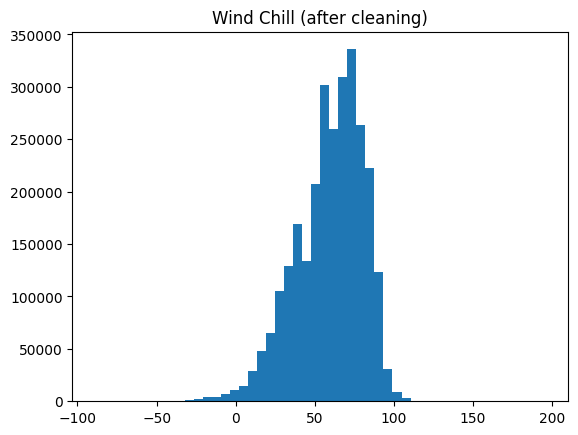

In [106]:
# confirm that the distribution is relatively unchanged
plt.hist(data_cleaned['Wind_Chill(F)'], bins=50)
plt.title("Wind Chill (after cleaning)")
plt.show()

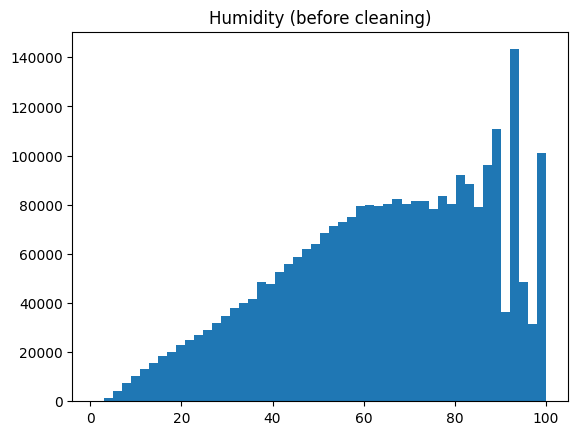

In [107]:
plt.hist(data_cleaned['Humidity(%)'], bins=50)
plt.title("Humidity (before cleaning)")
plt.show()

In [108]:
# humidity follows a distribution that seems reasonable to sample from randomly
humidity_sample = data_cleaned['Humidity(%)'].dropna().sample(n=len(data_cleaned), replace=True)
humidity_sample.index = data_cleaned.index
data_cleaned['Humidity(%)'] = data_cleaned['Humidity(%)'].fillna(humidity_sample)

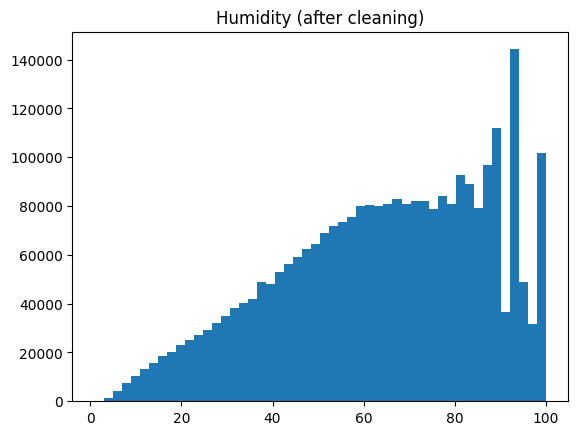

In [109]:
# confirm that the distribution is relatively unchanged
plt.hist(data_cleaned['Humidity(%)'], bins=50)
plt.title("Humidity (after cleaning)")
plt.show()

count    2.786142e+06
mean     2.947234e+01
std      1.045286e+00
min      0.000000e+00
25%      2.931000e+01
50%      2.982000e+01
75%      3.001000e+01
max      5.890000e+01
Name: Pressure(in), dtype: float64
58.9


<AxesSubplot:>

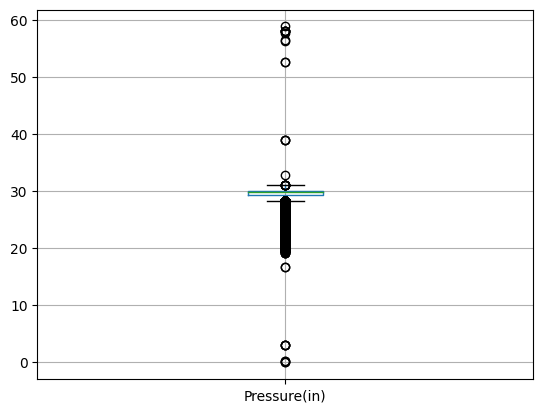

In [110]:
print(data_cleaned['Pressure(in)'].describe())
print(max(data_cleaned['Pressure(in)']))

data_cleaned.boxplot('Pressure(in)')

In [111]:
# the distribution for pressure is irregular, so filling NAs with the median is safest
pressure_median = data_cleaned['Pressure(in)'].median()
data_cleaned['Pressure(in)'] = data_cleaned['Pressure(in)'].fillna(pressure_median)

count    2.774796e+06
mean     9.099391e+00
std      2.717546e+00
min      0.000000e+00
25%      1.000000e+01
50%      1.000000e+01
75%      1.000000e+01
max      1.400000e+02
Name: Visibility(mi), dtype: float64
140.0


<AxesSubplot:>

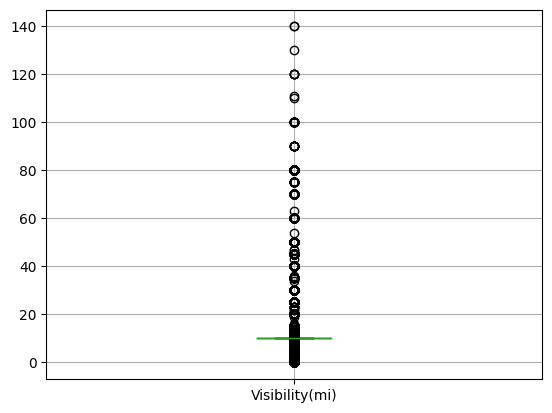

In [112]:
print(data_cleaned['Visibility(mi)'].describe())
print(max(data_cleaned['Visibility(mi)']))

data_cleaned.boxplot('Visibility(mi)')

It is reasonable that the majority of accidents occur with low visibility and very few occur with high visibility. A visibility up to 150 miles is technically possible, so the values of the outliers should be preserved.

In [113]:
# the distribution for visibility is irregular, so filling NAs with the median is safest
visibility_median = data_cleaned['Visibility(mi)'].median()
data_cleaned['Visibility(mi)'] = data_cleaned['Visibility(mi)'].fillna(visibility_median)

count    2.687398e+06
mean     7.395044e+00
std      5.527454e+00
min      0.000000e+00
25%      3.500000e+00
50%      7.000000e+00
75%      1.000000e+01
max      1.087000e+03
Name: Wind_Speed(mph), dtype: float64
1087.0


<AxesSubplot:>

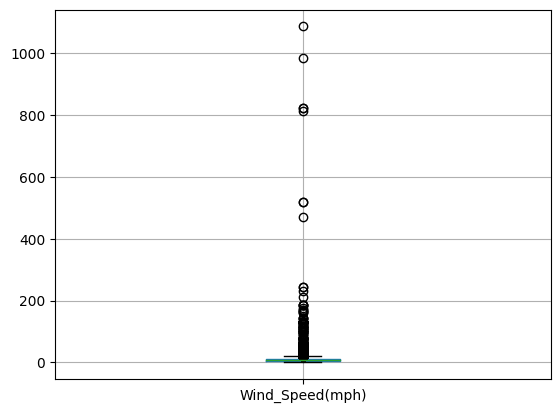

In [114]:
print(data_cleaned['Wind_Speed(mph)'].describe())
print(max(data_cleaned['Wind_Speed(mph)']))

data_cleaned.boxplot('Wind_Speed(mph)')

In [115]:
# the distribution for wind speed is irregular, so filling NAs with the median is safest
wind_speed_median = data_cleaned['Wind_Speed(mph)'].median()
data_cleaned['Wind_Speed(mph)'] = data_cleaned['Wind_Speed(mph)'].fillna(wind_speed_median)

count    2.295884e+06
mean     7.016940e-03
std      9.348831e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.400000e+01
Name: Precipitation(in), dtype: float64
24.0


<AxesSubplot:>

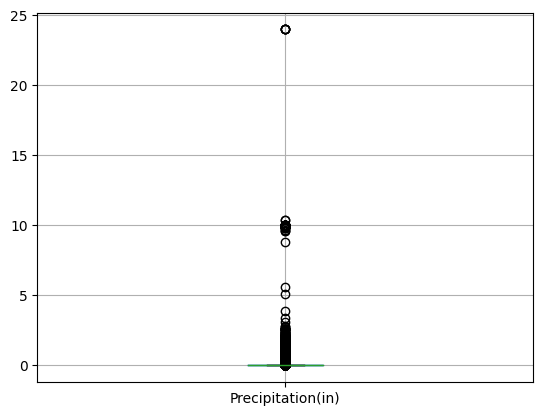

In [116]:
print(data_cleaned['Precipitation(in)'].describe())
print(max(data_cleaned['Precipitation(in)']))

data_cleaned.boxplot('Precipitation(in)')

In [117]:
# the distribution for precipitation is irregular, so filling NAs with the median is safest
precip_median = data_cleaned['Precipitation(in)'].median()
data_cleaned['Precipitation(in)'] = data_cleaned['Precipitation(in)'].fillna(precip_median)

In [118]:
data_cleaned['Weather_Condition'].value_counts()

Fair                        1107194
Mostly Cloudy                363959
Cloudy                       348767
Partly Cloudy                249939
Clear                        173823
                             ...   
Sleet / Windy                     1
Mist / Windy                      1
Blowing Sand                      1
Heavy Freezing Rain               1
Thunder and Hail / Windy          1
Name: Weather_Condition, Length: 127, dtype: int64

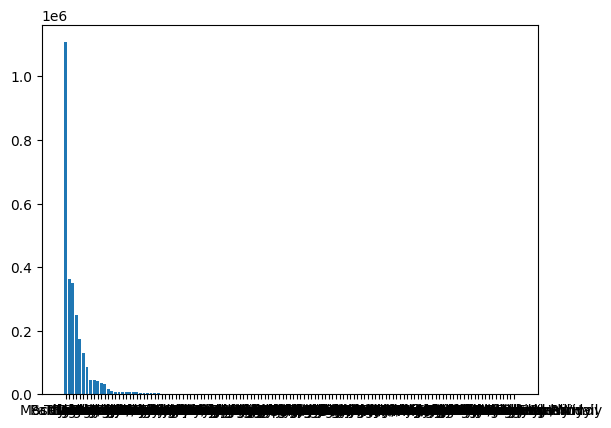

In [119]:
x_labels = list(data_cleaned['Weather_Condition'].value_counts().index)
y_vals = list(data_cleaned['Weather_Condition'].value_counts())

plt.bar(x_labels, y_vals)
plt.show()

In [120]:
# weather condition follows a distribution that seems reasonable to sample from randomly
weather_sample = data_cleaned['Weather_Condition'].dropna().sample(n=len(data_cleaned), replace=True)
weather_sample.index = data_cleaned.index
data_cleaned['Weather_Condition'] = data_cleaned['Weather_Condition'].fillna(weather_sample)

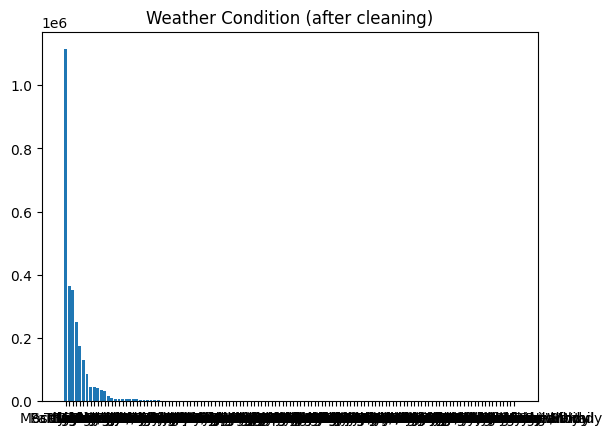

In [121]:
# confirm that the distribution is relatively unchanged
x_labels = list(data_cleaned['Weather_Condition'].value_counts().index)
y_vals = list(data_cleaned['Weather_Condition'].value_counts())

plt.bar(x_labels, y_vals)
plt.title("Weather Condition (after cleaning)")
plt.show()

In [122]:
print(f"Number of remaining NAs: {data_cleaned.isna().any(axis=1).sum()}")

Number of remaining NAs: 0
